#### Print your name

In [1]:
## Your code here 
print("Exercise by: Heidi Putkuri")

Exercise by: Heidi Putkuri


# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import sys
sys.path.insert(0, '../answers')
import helper

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.


***
### Exercise:
Define needed transforms for training images and testing images.

**Use parameters:**
- mini-batch size = 64
- Use normalization 

In [ ]:
## Task 1:
## Your code here 

path_train = '../data/Cat_Dog_data/train'
path_test = '../data/Cat_Dog_data/test'
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(path_train, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

test_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
test_data = datasets.ImageFolder(path_test, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


***
We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [4]:
model = models.densenet121(weights='DEFAULT')
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/heksaani/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 24.9MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [11]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(1024, 500)),
                            ('relu', nn.ReLU()),
                            ('fc2', nn.Linear(500, 2)),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [12]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)

False
2.5.1


In [13]:
import time

In [15]:
for device in ['cpu']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 2.008 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.



***
### Exercise: 
Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

**Use following parameters:**
- Print train loss, test loss and test accuracy after every mini-batch
- Run training only 35 mini-batches (=64*35=2240 images)
- Save result to following parameters: 
`train_losses, test_losses, test_accuracies = [], [], []`


In [ ]:
## Task 2:
## Your code here 

device = 'cuda'

train_losses, test_losses, test_accuracies = [], [], []
num_batches = 35
model.to(device)
model.train()
batch_count = 0
epochs = 1
max_train_steps = num_batches
for epoch in range(epochs):
    for step, (inputs, labels) in enumerate(trainloader, 1):
        if step > max_train_steps: # stop after 35 minibatches
            break


        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients and record the training start time
        optimizer.zero_grad()
        train_batch_start = time.time()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        train_time = time.time() - train_batch_start
        train_losses.append(loss.item())

        model.eval() #evaluation mode on
        test_batch_start = time.time()
        test_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for inputs_test, labels_test in testloader:
                inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
                outputs_test = model(inputs_test)
                test_loss += criterion(outputs_test, labels_test).item()
                _, predicted = torch.max(outputs_test, 1)
                correct_predictions += (predicted == labels_test).sum().item()
                total_predictions += labels_test.size(0)

        test_time = time.time() - test_batch_start
        avg_test_loss = test_loss / len(testloader)
        test_accuracy = correct_predictions / total_predictions

        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Train time [s]: {train_time}    Test time [s]: {test_time}")
        print(f"Epoch: {epoch+1}/{epochs}  Step: {step}  "
                f"Training Loss: {loss.item():.3f}  Test Loss: {avg_test_loss:.3f}  Test Accuracy: {test_accuracy:.3f}")
        print(f"Train batches / epoch: {len(trainloader)}    Test batches / epoch: {len(testloader)}")


print("training done!")


Train time [s]: 0.734600305557251    Test time [s]: 29.72808337211609
Train batches / epoch: 352    Test batches / epoch: 40
Epoch: 1/1..  Step: 1..  Training Loss: 0.735..  Test Loss: 0.541..  Test Accuracy: 0.932
Train time [s]: 0.6543760299682617    Test time [s]: 24.456243991851807
Train batches / epoch: 352    Test batches / epoch: 40
Epoch: 1/1..  Step: 2..  Training Loss: 0.577..  Test Loss: 0.410..  Test Accuracy: 0.957
Train time [s]: 0.629554271697998    Test time [s]: 15.236886501312256
Train batches / epoch: 352    Test batches / epoch: 40
Epoch: 1/1..  Step: 3..  Training Loss: 0.524..  Test Loss: 0.357..  Test Accuracy: 0.896
Train time [s]: 0.7267062664031982    Test time [s]: 14.980295419692993
Train batches / epoch: 352    Test batches / epoch: 40
Epoch: 1/1..  Step: 4..  Training Loss: 0.412..  Test Loss: 0.271..  Test Accuracy: 0.941
Train time [s]: 0.43702244758605957    Test time [s]: 13.474462509155273
Train batches / epoch: 352    Test batches / epoch: 40
Epoch: 

But still the network makes mistakes... 

***

### Exercise: 
Print 8 pictures of errors (with test images) in dog/cat -classification.
- save 8. image index to `last_index`
- save erroneous images to `error_images`

Batch 1 Image 0 [False] Prediction [1] Label 0
Batch 1 Image 28 [False] Prediction [1] Label 0
Batch 1 Image 33 [False] Prediction [1] Label 0
Batch 2 Image 33 [False] Prediction [1] Label 0
Batch 4 Image 41 [False] Prediction [1] Label 0
Batch 5 Image 15 [False] Prediction [1] Label 0
Batch 7 Image 9 [False] Prediction [1] Label 0
Batch 9 Image 21 [False] Prediction [1] Label 0
597 images checked to find 8 errors.
Accuracy: 0.9865996649916248


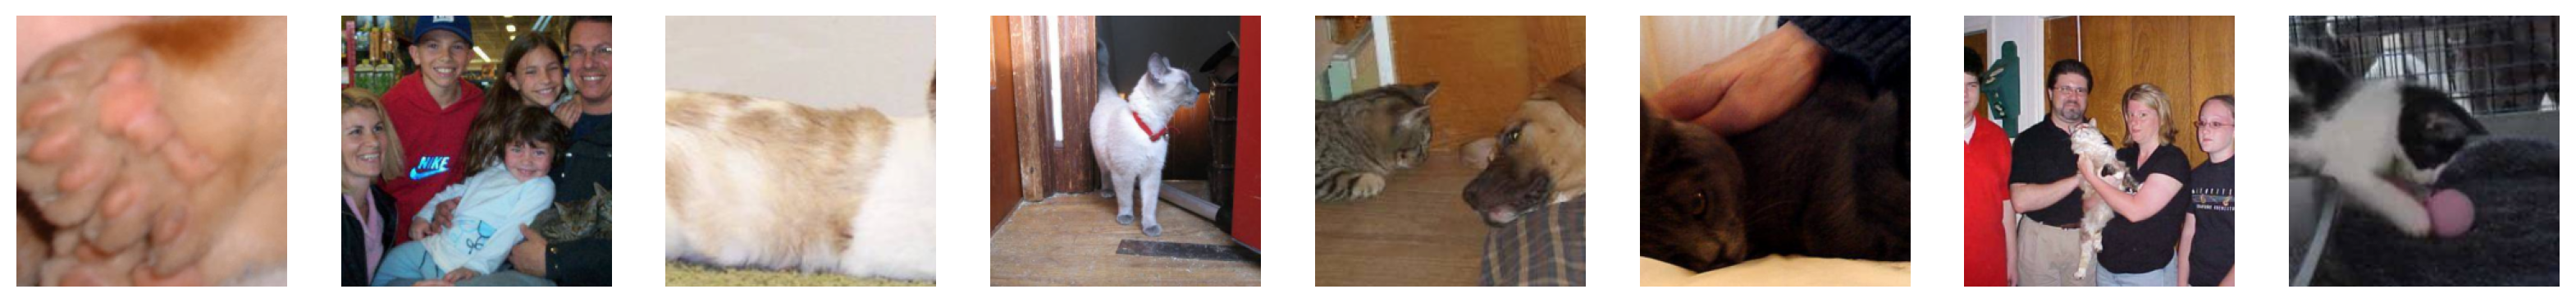

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

error_images = []
errors_found = 0
last_index = None
correct_predictions = 0
total_predictions = 0

for batch, (images, labels) in enumerate(testloader, start=1):  # Iterate through batches in the testloader
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)  # forward pass
        ps = torch.exp(outputs)  # convert logits to probabilities
        _, predicted = torch.max(ps, 1)

        misclassified = predicted == labels

        for i, is_misclassified in enumerate(misclassified):
            if not is_misclassified:
                print(f"Batch {batch} Image {i} [{is_misclassified}] Prediction [{predicted[i].item()}] Label [{labels[i].item()}]")
                error_images.append(images[i])  # Store misclassified images
                errors_found += 1
                last_index = i  # Store the index of the misclassified image

            correct_predictions += (predicted[i] == labels[i]).item()
            total_predictions += 1 

            if errors_found == 8:
                break 

    # Stop processing once 8 errors are found
    if errors_found == 8:
        break

accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f'{total_predictions} images checked to find 8 errors.')
print(f'Accuracy: {accuracy:.16f}')
fig, axes = plt.subplots(figsize=(10,4), ncols=8)

for ii in range(min(8, len(error_images))):
    ax = axes[ii]
    helper.imshow(error_images[ii].cpu(), ax=ax, normalize=True)


***

## Reflection

Answer briefly following questions (in English or Finnish):
- What is CUDA?
- Why GPU is faster than CPU?
- How many pre-trained image network can you find from torchvision models?
- What kind of pictures network mislabels? Are those still easy for a human to classify?




*Your answers here...*

### Check your answers by running following cell:

Train:
Dataset ImageFolder
    Number of datapoints: 22500
    Root location: /home/jovyan/shared/Cat_Dog_data//train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Mini-batch size: 64
Traindata loader: 22528


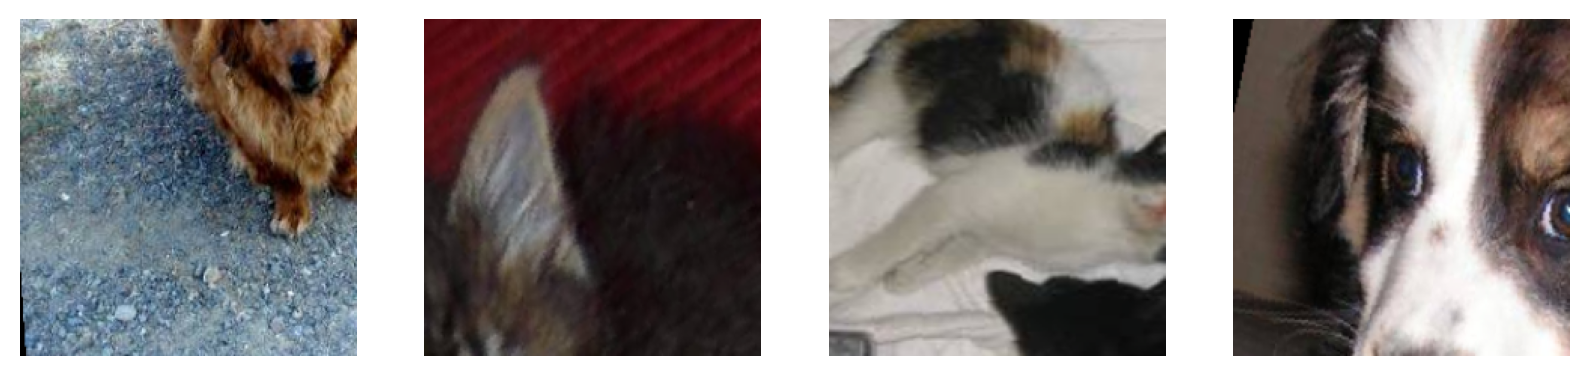

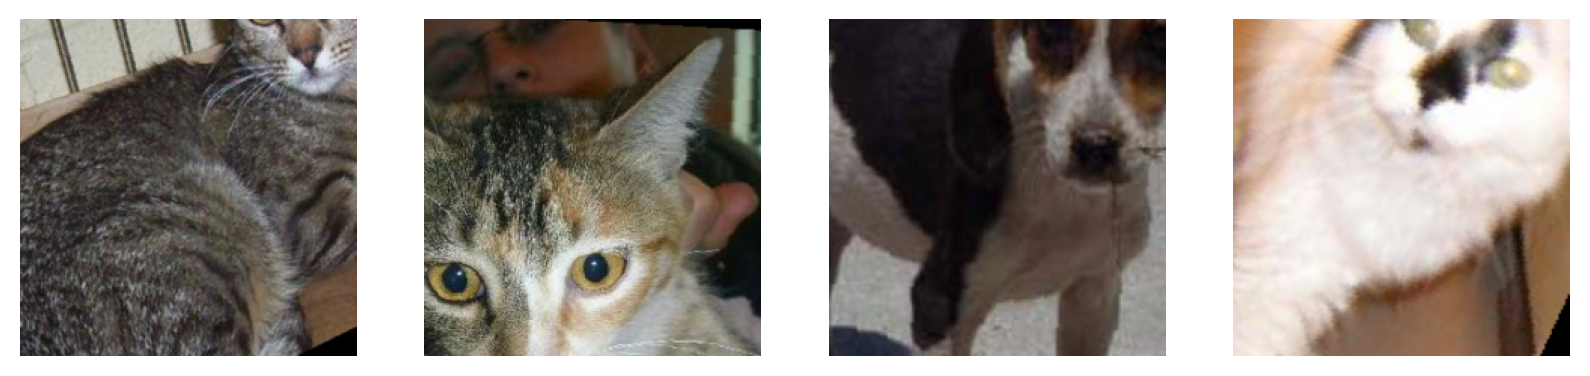

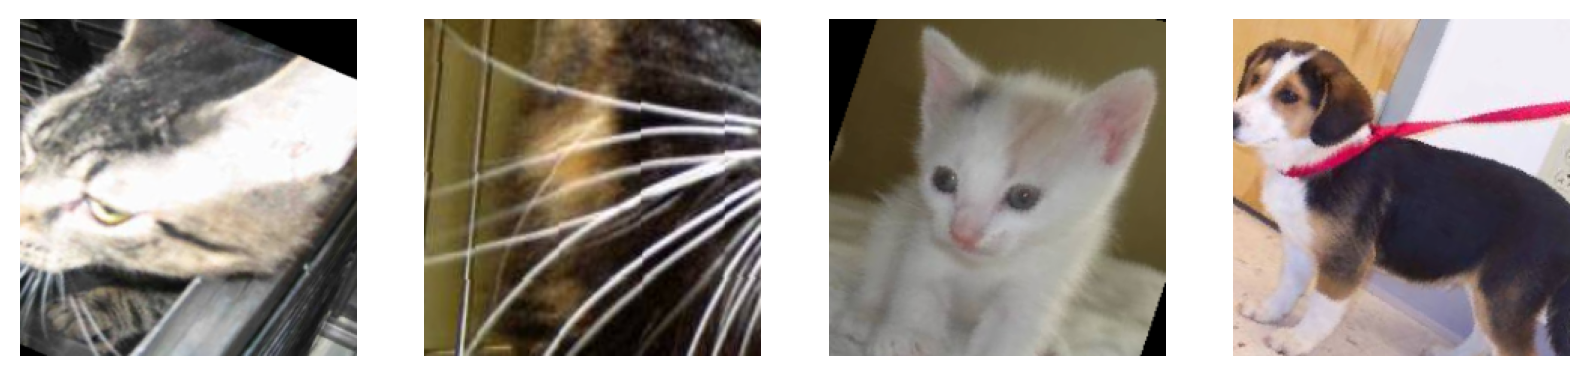

In [11]:
# Do not change this code!

print("Train:")
print(train_data)
print(train_transforms)
print("Mini-batch size:", trainloader.batch_size)
print("Traindata loader:", len(trainloader)*trainloader.batch_size)
for ii in range(3):
    data_iter = iter(trainloader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(figsize=(10,4), ncols=4)
    for ii in range(4):
        ax = axes[ii]
        helper.imshow(images[ii], ax=ax, normalize=True)

Test:
Dataset ImageFolder
    Number of datapoints: 2501
    Root location: /home/jovyan/shared/Cat_Dog_data//test
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Compose(
    Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Mini-batch size: 64
Traindata loader: 2560


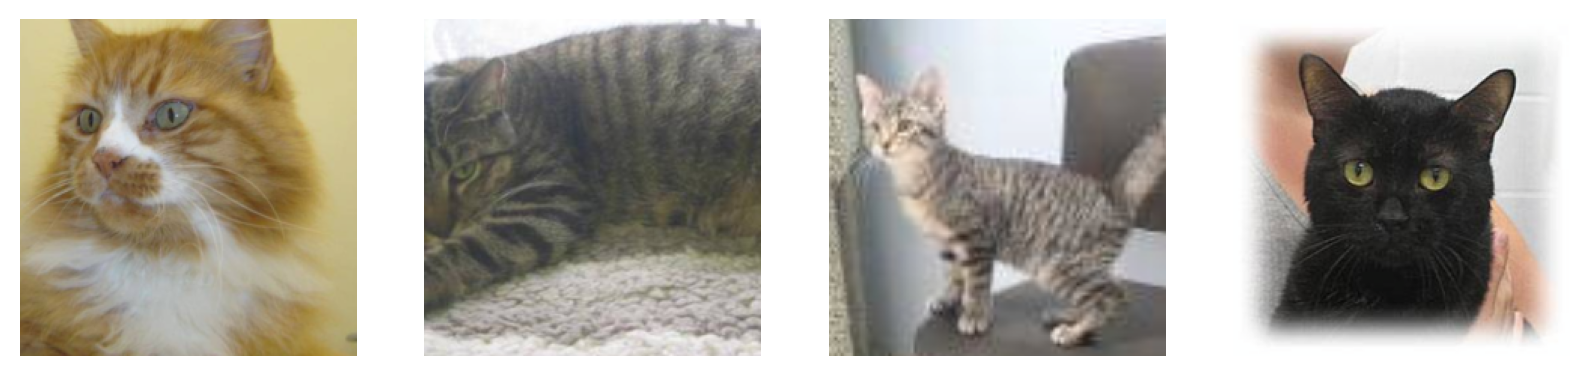

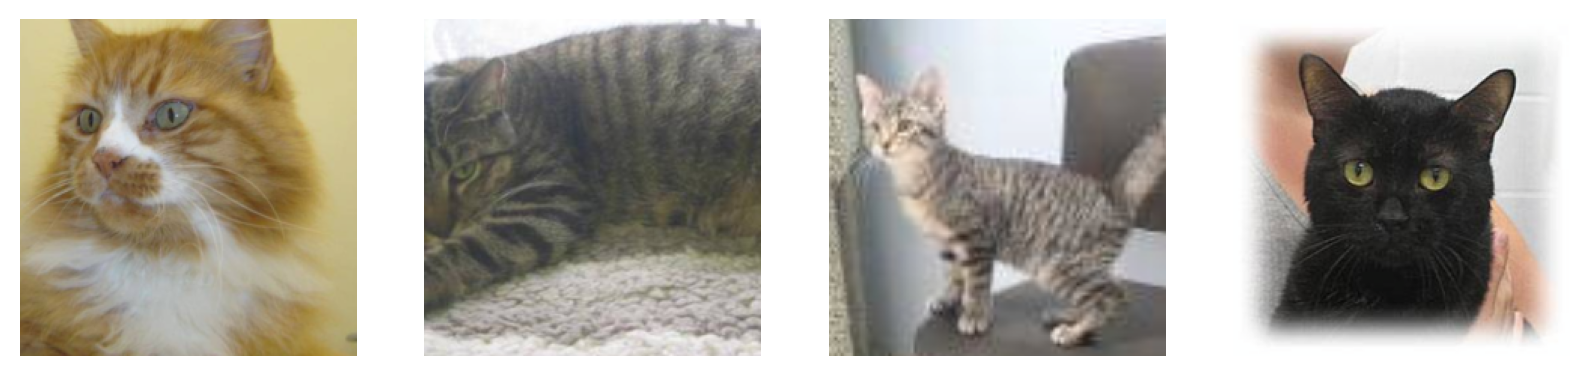

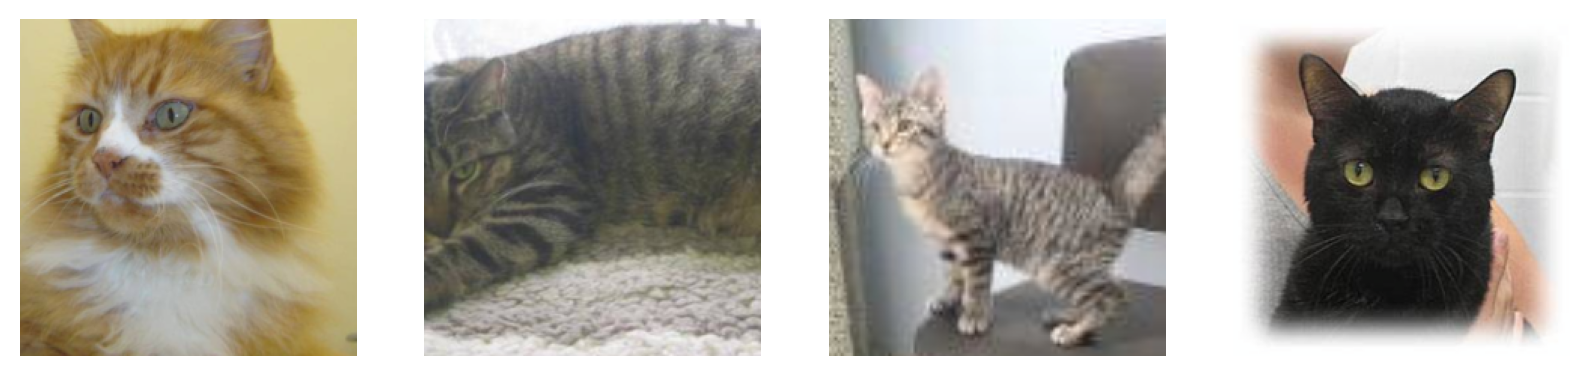

In [12]:
# Do not change this code!

print("Test:")
print(test_data)
print(test_transforms)
print("Mini-batch size:", testloader.batch_size)
print("Traindata loader:", len(testloader)*testloader.batch_size)
for ii in range(3):
    data_iter = iter(testloader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(figsize=(10,4), ncols=4)
    for ii in range(4):
        ax = axes[ii]
        helper.imshow(images[ii], ax=ax, normalize=True)

In [13]:
model.features

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

In [14]:
model.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)

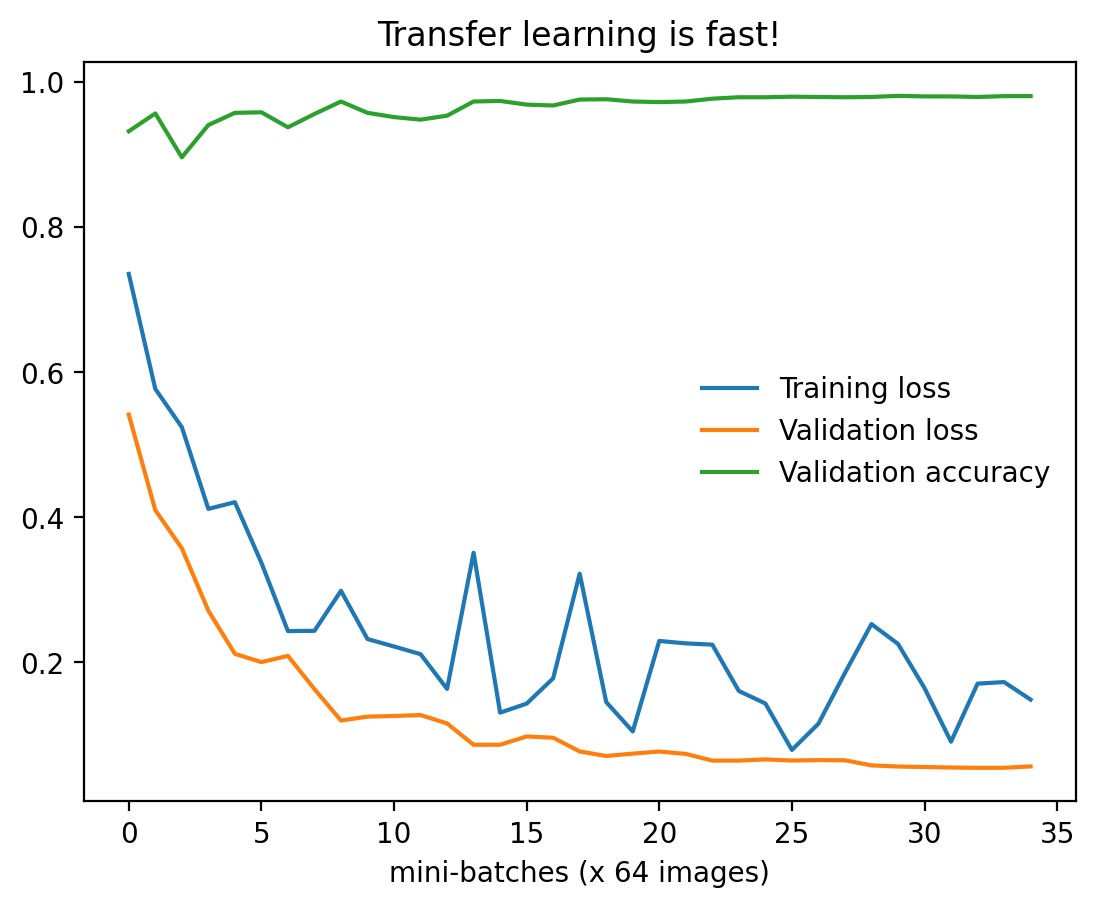

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.plot(test_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('mini-batches (x 64 images)');
plt.title('Transfer learning is fast!');

8 errors with 597 images. => Accuracy: 0.9865996649916248


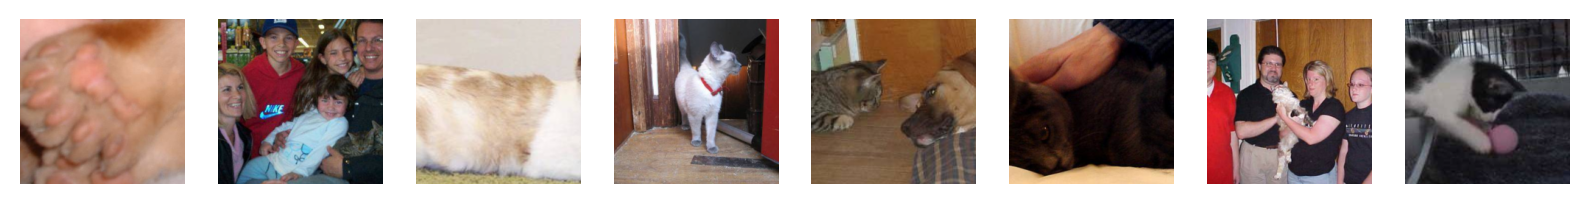

In [16]:
print('8 errors with', last_index, 'images. => Accuracy:', (last_index-8)/last_index)
fig, axes = plt.subplots(figsize=(10,4), ncols=len(error_images))
for ii in range(len(error_images)):
    ax = axes[ii]
    helper.imshow(error_images[ii], ax=ax, normalize=True)

### Great work!